# Simplified Solution (Minimal Code)

This section shows a bare-minimum workflow: load data, plot 3D scatter, fit simple Lasso and Ridge with a few C values, show one prediction surface, and do a straightforward 5-fold CV for Lasso.

Data file used: `week3.csv` (first line is the dataset id).


In [61]:
# minimal imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# load data (skip header line with id)
data = np.loadtxt('week3.csv', delimiter=',', skiprows=1)
X = data[:, :2]
y = data[:, 2]
print('data shapes:', X.shape, y.shape)


data shapes: (199, 2) (199,)


In [65]:
# polynomial features (degree 5)
poly = PolynomialFeatures(degree=5, include_bias=True)
Xpoly = poly.fit_transform(X)

# simple sweep over C values
def C_to_alpha(C):
    return 1.0/(2.0*C)

C_list = [0.1, 1, 10]

# Lasso fit
lasso_results = []
for C in C_list:
    model = Lasso(alpha=C_to_alpha(C), max_iter=10000)
    model.fit(Xpoly, y)
    pred = model.predict(Xpoly)
    mse = mean_squared_error(y, pred)
    lasso_results.append((C, mse, model))

# Ridge fit
ridge_results = []
for C in C_list:
    model = Ridge(alpha=C_to_alpha(C))
    model.fit(Xpoly, y)
    pred = model.predict(Xpoly)
    mse = mean_squared_error(y, pred)
    ridge_results.append((C, mse, model))

print('Lasso (C, MSE):', [(c, round(m,4)) for c,m,_ in lasso_results])
print('Ridge (C, MSE):', [(c, round(m,4)) for c,m,_ in ridge_results])


Lasso (C, MSE): [(0.1, 0.4574), (1, 0.4574), (10, 0.0772)]
Ridge (C, MSE): [(0.1, 0.0455), (1, 0.037), (10, 0.0351)]


/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2

best lasso C: 10 MSE: 0.0772


/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


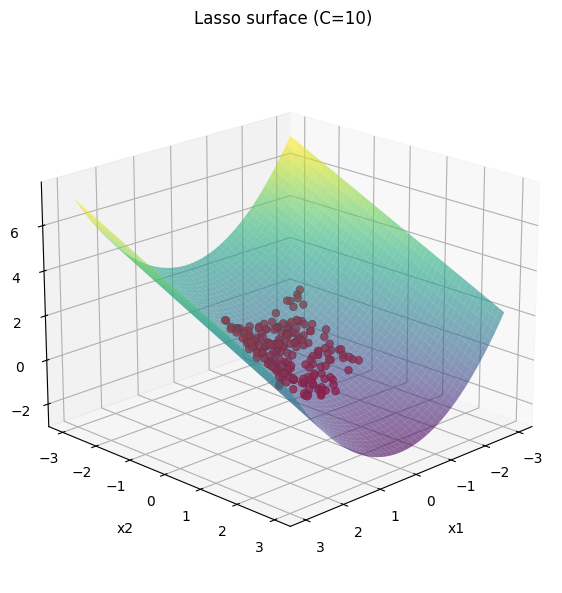

In [67]:
# plot best lasso model
best_C, best_mse, best_model = sorted(lasso_results, key=lambda t: t[1])[0]
print('best lasso C:', best_C, 'MSE:', round(best_mse,4))

# extend grid beyond data range
x1_range = X[:,0].max() - X[:,0].min()
x2_range = X[:,1].max() - X[:,1].min()
x1_min = X[:,0].min() - 1.0*x1_range
x1_max = X[:,0].max() + 1.0*x1_range
x2_min = X[:,1].min() - 1.0*x2_range
x2_max = X[:,1].max() + 1.0*x2_range

xx = np.linspace(x1_min, x1_max, 50)
yy = np.linspace(x2_min, x2_max, 50)
X1g, X2g = np.meshgrid(xx, yy)
Xg = np.c_[X1g.ravel(), X2g.ravel()]
Xg_poly = poly.transform(Xg)
Z = best_model.predict(Xg_poly).reshape(X1g.shape)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1g, X2g, Z, alpha=0.6, cmap='viridis', edgecolor='none')
ax.scatter(X[:,0], X[:,1], y, s=30, c='r', alpha=0.8, edgecolors='darkred', linewidths=0.5)
ax.set_title(f'Lasso surface (C={best_C})', fontsize=12, pad=15)
ax.set_xlabel('x1', fontsize=10, labelpad=10)
ax.set_ylabel('x2', fontsize=10, labelpad=10)
ax.set_zlabel('y', fontsize=10, labelpad=10)
ax.view_init(elev=20, azim=45)
ax.grid(True, alpha=0.3)
plt.savefig('figures/01_simple_lasso_surface.png', dpi=300, bbox_inches='tight')
plt.show()


In [29]:
# very simple 5-fold CV for Lasso over few C values
kf = KFold(n_splits=5, shuffle=True, random_state=0)
C_try = [0.1, 1, 10]
cv_means = []
cv_stds = []

for C in C_try:
    mses = []
    for train_idx, test_idx in kf.split(Xpoly):
        model = Lasso(alpha=C_to_alpha(C), max_iter=10000)
        model.fit(Xpoly[train_idx], y[train_idx])
        pred = model.predict(Xpoly[test_idx])
        mses.append(mean_squared_error(y[test_idx], pred))
    cv_means.append(np.mean(mses))
    cv_stds.append(np.std(mses))

print('CV Lasso (C, mean MSE, std):')
for i, C in enumerate(C_try):
    print(C, round(cv_means[i],4), round(cv_stds[i],4))


CV Lasso (C, mean MSE, std):
0.1 0.4593 0.0817
1 0.4593 0.0817
10 0.0799 0.0202


## Question (i)(a): 3D Scatter Plot
Does the data look like it lies on a plane or curve?


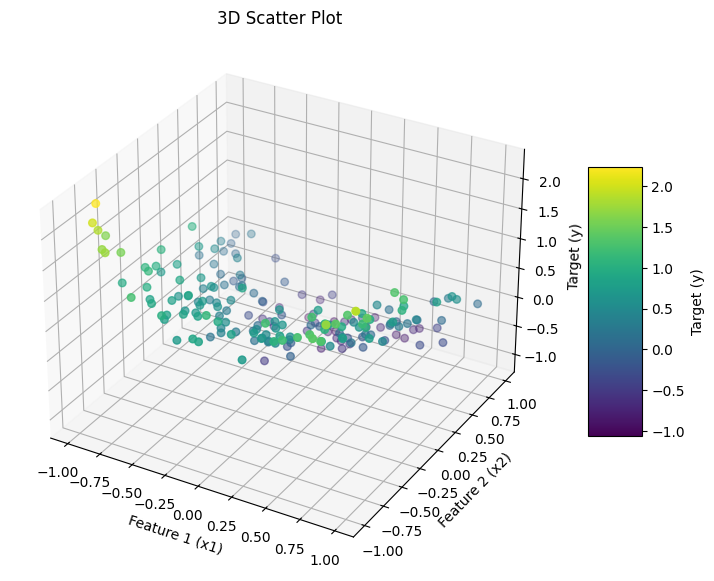

The data appears to have a curved relationship, not a simple plane.


In [68]:
# Question (i)(a): 3D scatter plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# plot points colored by target value
scatter = ax.scatter(X[:,0], X[:,1], y, c=y, cmap='viridis', s=30)

ax.set_xlabel('Feature 1 (x1)')
ax.set_ylabel('Feature 2 (x2)')
ax.set_zlabel('Target (y)')
ax.set_title('3D Scatter Plot')

# add colorbar
plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='Target (y)')

plt.savefig('figures/02_3d_scatter_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("The data appears to have a curved relationship, not a simple plane.")


## Question (i)(b): Lasso Regression with Polynomial Features


In [48]:
# Question (i)(b): Lasso with polynomial features up to power 5
poly = PolynomialFeatures(degree=5, include_bias=True)
Xpoly = poly.fit_transform(X)
print("Polynomial features shape:", Xpoly.shape)

# try different C values
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
lasso_models = {}

print("\nLasso Results:")
print("C\t\tNon-zero coeffs\tMSE")
print("-" * 40)

for C in C_values:
    model = Lasso(alpha=1/(2*C), max_iter=10000)
    model.fit(Xpoly, y)
    
    pred = model.predict(Xpoly)
    mse = mean_squared_error(y, pred)
    non_zero = np.sum(np.abs(model.coef_) > 1e-10)
    
    lasso_models[C] = model
    
    print(f"{C}\t\t{non_zero}\t\t{mse:.4f}")

# show feature names
feature_names = poly.get_feature_names_out(['x1', 'x2'])
print(f"\nPolynomial features: {len(feature_names)} total")
for i, name in enumerate(feature_names):
    print(f"{i:2d}: {name}")


Polynomial features shape: (199, 21)

Lasso Results:
C		Non-zero coeffs	MSE
----------------------------------------
0.001		0		0.4574
0.01		0		0.4574
0.1		0		0.4574
1		0		0.4574
10		2		0.0772
100		2		0.0392
1000		10		0.0368

Polynomial features: 21 total
 0: 1
 1: x1
 2: x2
 3: x1^2
 4: x1 x2
 5: x2^2
 6: x1^3
 7: x1^2 x2
 8: x1 x2^2
 9: x2^3
10: x1^4
11: x1^3 x2
12: x1^2 x2^2
13: x1 x2^3
14: x2^4
15: x1^5
16: x1^4 x2
17: x1^3 x2^2
18: x1^2 x2^3
19: x1 x2^4
20: x2^5


/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2

In [49]:
# show coefficients for selected C values
print("Detailed Lasso Coefficients:")
print("=" * 50)

for C in [0.001, 10, 100, 1000]:
    print(f"\nC = {C}:")
    model = lasso_models[C]
    coeffs = model.coef_
    non_zero_indices = np.where(np.abs(coeffs) > 1e-10)[0]
    
    if len(non_zero_indices) == 0:
        print("  All coefficients are zero")
    else:
        print("  Non-zero coefficients:")
        for idx in non_zero_indices:
            print(f"    {feature_names[idx]}: {coeffs[idx]:.6f}")
    print(f"  Total: {len(non_zero_indices)}/{len(coeffs)}")


Detailed Lasso Coefficients:

C = 0.001:
  All coefficients are zero
  Total: 0/21

C = 10:
  Non-zero coefficients:
    x2: -0.845251
    x1^2: 0.510417
  Total: 2/21

C = 100:
  Non-zero coefficients:
    x2: -0.987955
    x1^2: 1.060313
  Total: 2/21

C = 1000:
  Non-zero coefficients:
    x2: -1.049456
    x1^2: 1.109467
    x1 x2: -0.179636
    x1^3: -0.012399
    x1^2 x2: 0.044510
    x1^3 x2: 0.213033
    x1^4 x2: -0.094151
    x1^3 x2^2: -0.008270
    x1 x2^4: -0.033363
    x2^5: 0.125468
  Total: 10/21


## Question (i)(c): Generate Predictions and 3D Visualization


/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2

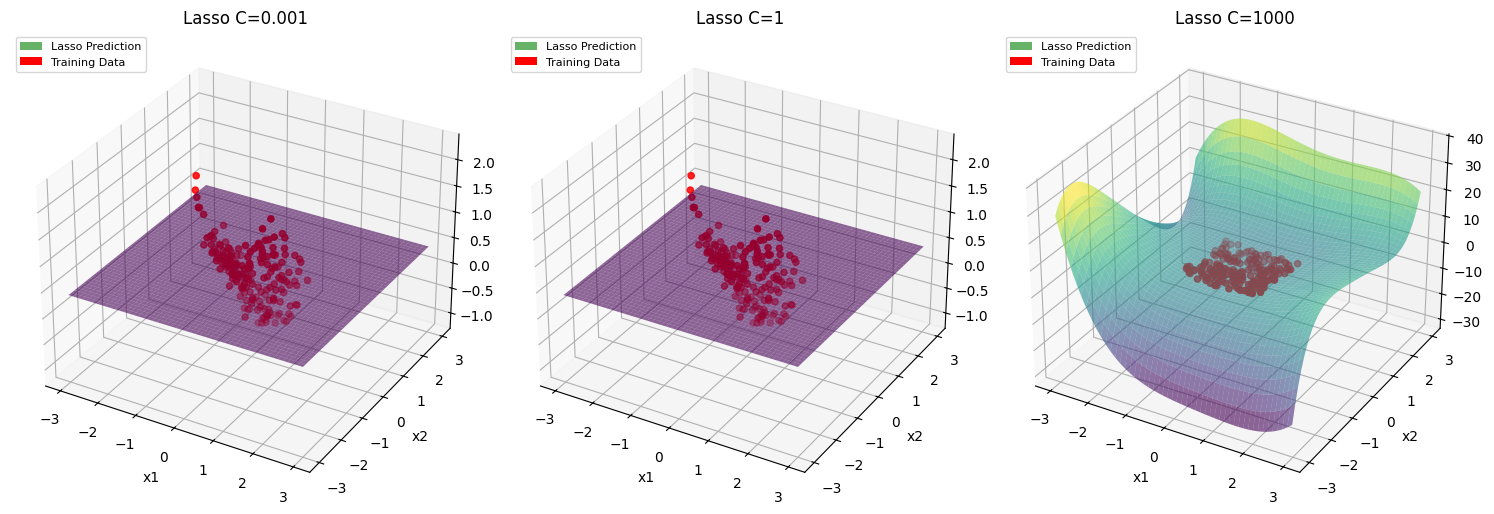


Observations:
- C=0.001: Heavily regularized, nearly flat (underfitting)
- C=1: Moderate regularization
- C=1000: Low regularization, complex surface


In [69]:
# Question (i)(c): Generate predictions and plot surfaces
# extend grid beyond data range
x1_range = X[:,0].max() - X[:,0].min()
x2_range = X[:,1].max() - X[:,1].min()
x1_min = X[:,0].min() - 1.0*x1_range
x1_max = X[:,0].max() + 1.0*x1_range
x2_min = X[:,1].min() - 1.0*x2_range
x2_max = X[:,1].max() + 1.0*x2_range

# create grid for predictions
xx = np.linspace(x1_min, x1_max, 50)
yy = np.linspace(x2_min, x2_max, 50)
X1, X2 = np.meshgrid(xx, yy)

Xgrid = np.c_[X1.ravel(), X2.ravel()]
Xgrid_poly = poly.transform(Xgrid)

# plot surfaces for different C values
from matplotlib.patches import Patch
fig = plt.figure(figsize=(15, 10))

C_to_plot = [0.001, 1, 1000]
for i, C in enumerate(C_to_plot):
    model = lasso_models[C]
    ypred = model.predict(Xgrid_poly)
    ypred = ypred.reshape(X1.shape)
    
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    ax.plot_surface(X1, X2, ypred, alpha=0.6, cmap='viridis')
    ax.scatter(X[:,0], X[:,1], y, c='red', s=20)
    ax.set_title(f'Lasso C={C}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')
    # Add legend
    legend_elements = [Patch(facecolor='green', alpha=0.6, label='Lasso Prediction'),
                       Patch(facecolor='red', label='Training Data')]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig('figures/03_lasso_prediction_surfaces.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nObservations:")
print("- C=0.001: Heavily regularized, nearly flat (underfitting)")
print("- C=1: Moderate regularization")
print("- C=1000: Low regularization, complex surface")


## Question (i)(d): Underfitting and Overfitting Analysis


/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2

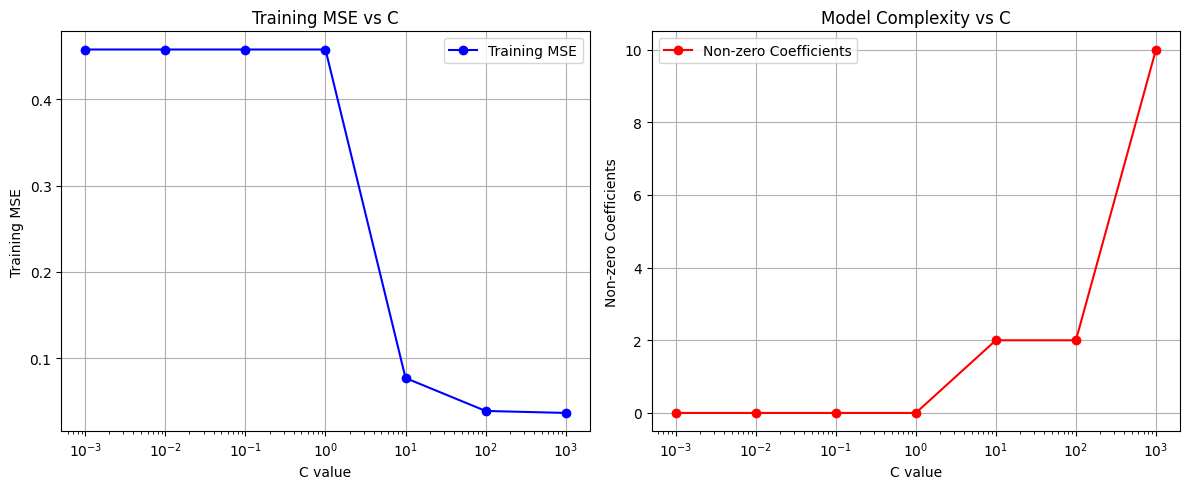

Underfitting and Overfitting Analysis:
Small C (high regularization):
  C=0.001: MSE=0.4574, Coeffs=0
  -> underfitting

Medium C:
  C=1: MSE=0.4574, Coeffs=0

Large C (low regularization):
  C=1000: MSE=0.0368, Coeffs=10
  -> possibly overfitting


In [70]:
# Question (i)(d): Analyze underfitting and overfitting
# calculate training MSE and number of non-zero coefficients
mse_list = []
coeff_count = []

for C in C_values:
    model = lasso_models[C]
    pred = model.predict(Xpoly)
    mse = mean_squared_error(y, pred)
    non_zero = np.sum(np.abs(model.coef_) > 1e-10)
    
    mse_list.append(mse)
    coeff_count.append(non_zero)

# plot analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.semilogx(C_values, mse_list, 'bo-', label='Training MSE')
ax1.set_xlabel('C value')
ax1.set_ylabel('Training MSE')
ax1.set_title('Training MSE vs C')
ax1.legend(loc='best')
ax1.grid(True)

ax2.semilogx(C_values, coeff_count, 'ro-', label='Non-zero Coefficients')
ax2.set_xlabel('C value')
ax2.set_ylabel('Non-zero Coefficients')
ax2.set_title('Model Complexity vs C')
ax2.legend(loc='best')
ax2.grid(True)

plt.tight_layout()
plt.savefig('figures/04_underfitting_overfitting_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Underfitting and Overfitting Analysis:")
print("=" * 40)
print("Small C (high regularization):")
print(f"  C=0.001: MSE={mse_list[0]:.4f}, Coeffs={coeff_count[0]}")
print("  -> underfitting")

print("\nMedium C:")
print(f"  C=1: MSE={mse_list[3]:.4f}, Coeffs={coeff_count[3]}")

print("\nLarge C (low regularization):")
print(f"  C=1000: MSE={mse_list[6]:.4f}, Coeffs={coeff_count[6]}")
print("  -> possibly overfitting")


## Question (i)(e): Ridge Regression Comparison


Ridge Results:
C		MSE
--------------------
0.001		0.3467
0.01		0.1211
0.1		0.0455
1		0.0370
10		0.0351
100		0.0349
1000		0.0349

Coefficient Comparison (C=1):
Feature			Lasso		Ridge
--------------------------------------------------
x1                  	 -0.0000	 -0.0031
x2                  	 -0.0000	 -1.0192
x1^2                	  0.0000	  0.9092
x1 x2               	  0.0000	 -0.1991
x2^2                	  0.0000	 -0.0510
x1^3                	 -0.0000	 -0.0756
x1^2 x2             	 -0.0000	  0.0879
x1 x2^2             	 -0.0000	  0.1180
x2^3                	 -0.0000	 -0.0616
x1^4                	  0.0000	  0.1976
x1^3 x2             	  0.0000	  0.1832
x1^2 x2^2           	  0.0000	  0.0344
x1 x2^3             	  0.0000	  0.0552
x2^4                	  0.0000	  0.0338
x1^5                	 -0.0000	  0.0873
x1^4 x2             	 -0.0000	 -0.1490
x1^3 x2^2           	 -0.0000	 -0.1033
x1^2 x2^3           	 -0.0000	 -0.0367
x1 x2^4             	 -0.0000	 -0.1118
x2^5                	 -0.0

/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: 

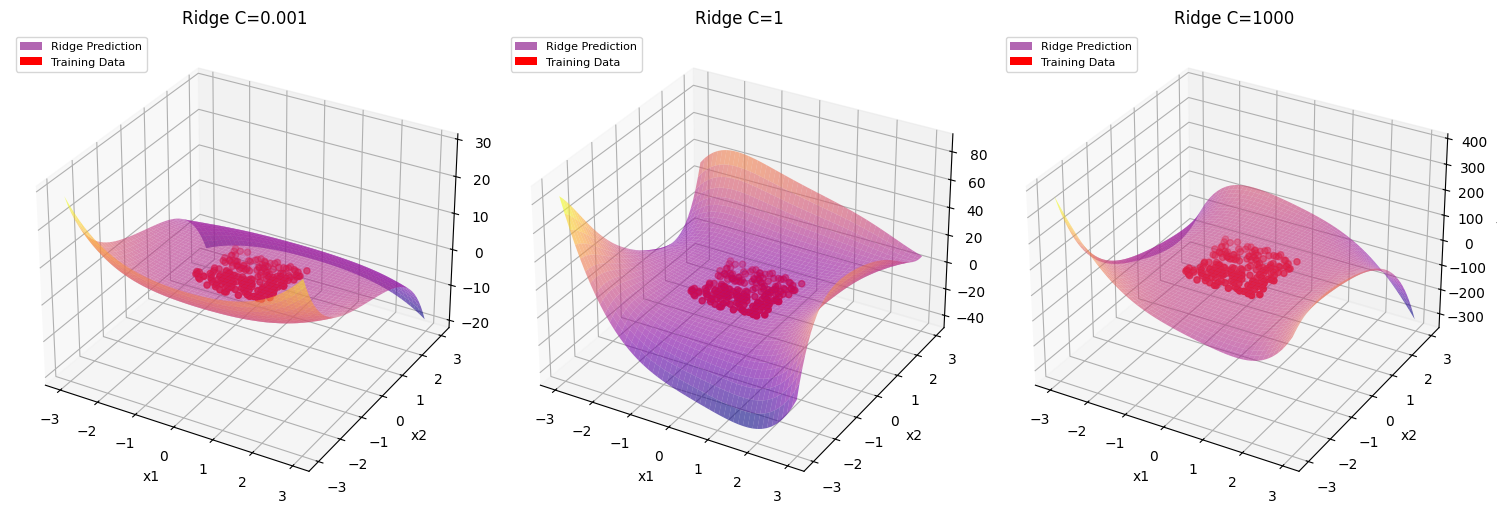


Ridge vs Lasso:
- Ridge keeps all features but shrinks coefficients
- Unlike Lasso, Ridge doesn't produce exactly zero coefficients


In [71]:
# Question (i)(e): Ridge regression comparison
ridge_models = {}

print("Ridge Results:")
print("C\t\tMSE")
print("-" * 20)

for C in C_values:
    model = Ridge(alpha=1/(2*C))
    model.fit(Xpoly, y)
    
    pred = model.predict(Xpoly)
    mse = mean_squared_error(y, pred)
    
    ridge_models[C] = model
    
    print(f"{C}\t\t{mse:.4f}")

# compare Lasso vs Ridge coefficients for C=1
print("\nCoefficient Comparison (C=1):")
print("=" * 40)
lasso_model = lasso_models[1]
ridge_model = ridge_models[1]

print("Feature\t\t\tLasso\t\tRidge")
print("-" * 50)
for i, name in enumerate(feature_names):
    lasso_val = lasso_model.coef_[i]
    ridge_val = ridge_model.coef_[i]
    if abs(lasso_val) > 1e-10 or abs(ridge_val) > 1e-10:
        print(f"{name:20s}\t{lasso_val:8.4f}\t{ridge_val:8.4f}")

# plot Ridge surfaces
from matplotlib.patches import Patch
fig = plt.figure(figsize=(15, 5))

C_to_plot = [0.001, 1, 1000]
for i, C in enumerate(C_to_plot):
    model = ridge_models[C]
    ypred = model.predict(Xgrid_poly)
    ypred = ypred.reshape(X1.shape)
    
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.plot_surface(X1, X2, ypred, alpha=0.6, cmap='plasma')
    ax.scatter(X[:,0], X[:,1], y, c='red', s=20)
    ax.set_title(f'Ridge C={C}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')
    # Add legend
    legend_elements = [Patch(facecolor='purple', alpha=0.6, label='Ridge Prediction'),
                       Patch(facecolor='red', label='Training Data')]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig('figures/05_ridge_prediction_surfaces.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nRidge vs Lasso:")
print("- Ridge keeps all features but shrinks coefficients")
print("- Unlike Lasso, Ridge doesn't produce exactly zero coefficients")


## Part (ii): Cross-Validation for Hyperparameter Selection

### Question (ii)(a): 5-Fold Cross-Validation for Lasso


5-Fold CV Results for Lasso:
C		Mean MSE	Std MSE
-----------------------------------
0.001		0.4670		0.1241
0.01		0.4670		0.1241
0.1		0.4670		0.1241
0.5		0.4670		0.1241
1		0.4670		0.1241
2		0.3571		0.1239
5		0.1801		0.0552
10		0.0814		0.0260
50		0.0416		0.0119
100		0.0408		0.0119
500		0.0419		0.0135
1000		0.0429		0.0146


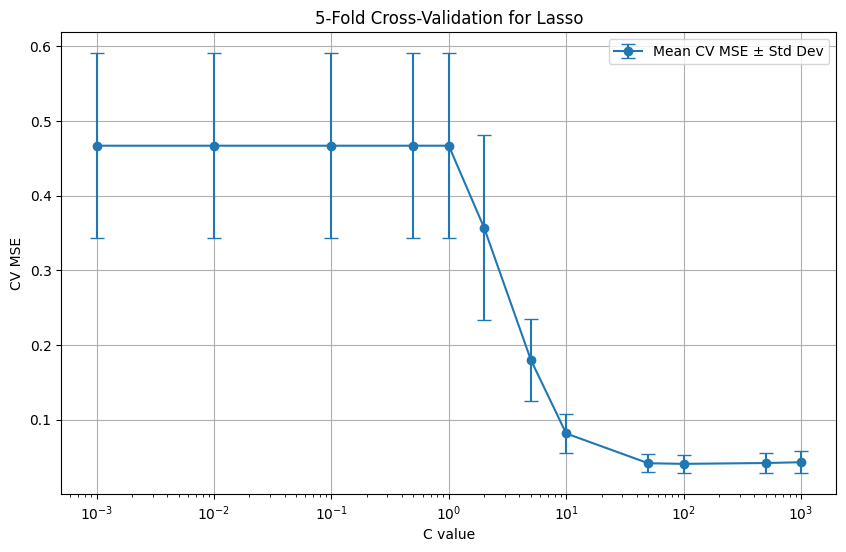

In [72]:
# Question (ii)(a): 5-fold cross-validation for Lasso
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# range of C values to try
C_cv = [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 50, 100, 500, 1000]
cv_means = []
cv_stds = []

print("5-Fold CV Results for Lasso:")
print("C\t\tMean MSE\tStd MSE")
print("-" * 35)

for C in C_cv:
    scores = []
    for train_idx, val_idx in kf.split(Xpoly):
        model = Lasso(alpha=1/(2*C), max_iter=10000)
        model.fit(Xpoly[train_idx], y[train_idx])
        pred = model.predict(Xpoly[val_idx])
        scores.append(mean_squared_error(y[val_idx], pred))
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    cv_means.append(mean_score)
    cv_stds.append(std_score)
    
    print(f"{C}\t\t{mean_score:.4f}\t\t{std_score:.4f}")

# plot CV results
plt.figure(figsize=(10, 6))
plt.errorbar(C_cv, cv_means, yerr=cv_stds, fmt='o-', capsize=5, label='Mean CV MSE ± Std Dev')
plt.xscale('log')
plt.xlabel('C value')
plt.ylabel('CV MSE')
plt.title('5-Fold Cross-Validation for Lasso')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('figures/06_lasso_cv_results.png', dpi=300, bbox_inches='tight')
plt.show()


### Question (ii)(b): Recommended C Value for Lasso


In [73]:
# Question (ii)(b): Find optimal C value
best_idx = np.argmin(cv_means)
best_C = C_cv[best_idx]
best_mse = cv_means[best_idx]
best_std = cv_stds[best_idx]

print(f"Optimal C value: {best_C}")
print(f"Best CV MSE: {best_mse:.4f} ± {best_std:.4f}")

# train final model with optimal C
final_lasso = Lasso(alpha=1/(2*best_C), max_iter=10000)
final_lasso.fit(Xpoly, y)

# show final model coefficients
print(f"\nFinal Lasso Model (C={best_C}) Coefficients:")
print("=" * 45)
non_zero_indices = np.where(np.abs(final_lasso.coef_) > 1e-10)[0]
for idx in non_zero_indices:
    print(f"{feature_names[idx]}: {final_lasso.coef_[idx]:.6f}")

print(f"\nTotal non-zero coefficients: {len(non_zero_indices)}/{len(final_lasso.coef_)}")

print(f"\nJustification:")
print(f"- Lowest CV MSE: {best_mse:.4f}")
print(f"- Features selected: {len(non_zero_indices)}")


Optimal C value: 100
Best CV MSE: 0.0408 ± 0.0119

Final Lasso Model (C=100) Coefficients:
x2: -0.987955
x1^2: 1.060313

Total non-zero coefficients: 2/21

Justification:
- Lowest CV MSE: 0.0408
- Features selected: 2


### Question (ii)(c): Cross-Validation for Ridge Regression


5-Fold CV Results for Ridge:
C		Mean MSE	Std MSE
-----------------------------------
0.001		0.3752		0.1071
0.01		0.1476		0.0476
0.1		0.0521		0.0164
0.5		0.0440		0.0140
1		0.0435		0.0142
2		0.0433		0.0146
5		0.0432		0.0151
10		0.0431		0.0154
50		0.0435		0.0161
100		0.0437		0.0164
500		0.0439		0.0167
1000		0.0440		0.0167


/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  

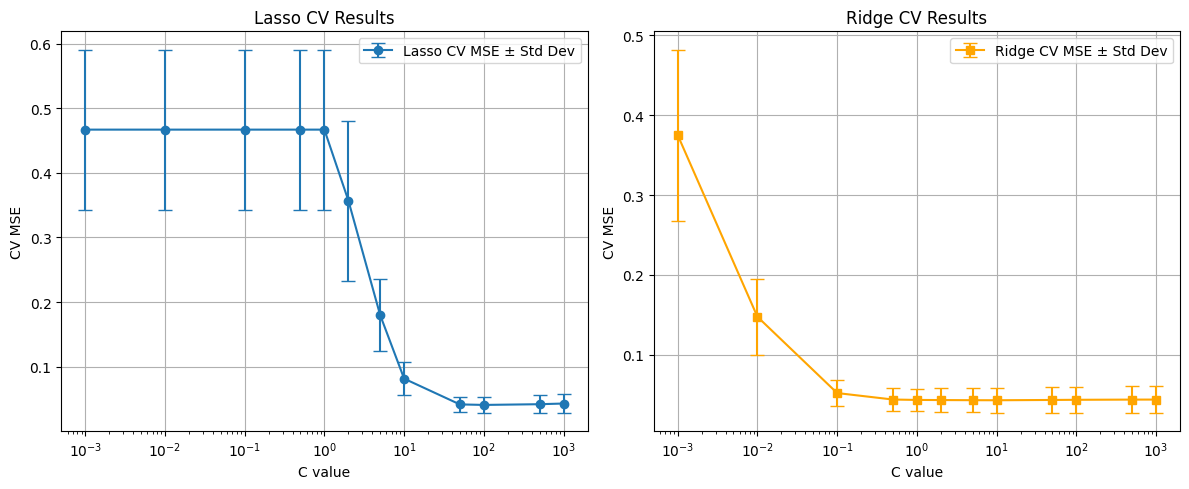


Optimal Ridge C: 10
Best Ridge CV MSE: 0.0431

Comparison:
Best Lasso (C=100): CV MSE = 0.0408
Best Ridge (C=10): CV MSE = 0.0431
Lasso performs better


In [74]:
# Question (ii)(c): 5-fold cross-validation for Ridge
ridge_cv_means = []
ridge_cv_stds = []

print("5-Fold CV Results for Ridge:")
print("C\t\tMean MSE\tStd MSE")
print("-" * 35)

for C in C_cv:
    scores = []
    for train_idx, val_idx in kf.split(Xpoly):
        model = Ridge(alpha=1/(2*C))
        model.fit(Xpoly[train_idx], y[train_idx])
        pred = model.predict(Xpoly[val_idx])
        scores.append(mean_squared_error(y[val_idx], pred))
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    ridge_cv_means.append(mean_score)
    ridge_cv_stds.append(std_score)
    
    print(f"{C}\t\t{mean_score:.4f}\t\t{std_score:.4f}")

# plot CV results comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.errorbar(C_cv, cv_means, yerr=cv_stds, fmt='o-', capsize=5, label='Lasso CV MSE ± Std Dev')
plt.xscale('log')
plt.xlabel('C value')
plt.ylabel('CV MSE')
plt.title('Lasso CV Results')
plt.legend(loc='best')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.errorbar(C_cv, ridge_cv_means, yerr=ridge_cv_stds, fmt='s-', capsize=5, label='Ridge CV MSE ± Std Dev', color='orange')
plt.xscale('log')
plt.xlabel('C value')
plt.ylabel('CV MSE')
plt.title('Ridge CV Results')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.savefig('figures/07_lasso_ridge_cv_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# find optimal Ridge C
best_ridge_idx = np.argmin(ridge_cv_means)
best_ridge_C = C_cv[best_ridge_idx]
best_ridge_mse = ridge_cv_means[best_ridge_idx]

print(f"\nOptimal Ridge C: {best_ridge_C}")
print(f"Best Ridge CV MSE: {best_ridge_mse:.4f}")

print(f"\nComparison:")
print(f"Best Lasso (C={best_C}): CV MSE = {best_mse:.4f}")
print(f"Best Ridge (C={best_ridge_C}): CV MSE = {best_ridge_mse:.4f}")

if best_mse < best_ridge_mse:
    print("Lasso performs better")
else:
    print("Ridge performs better")


## Final Summary


FINAL SUMMARY
Dataset: week3.csv
Data points: 199
Polynomial degree: 5 (21 features)

Best Lasso: C = 100, CV MSE = 0.0408, Coeffs = 2
Best Ridge: C = 10, CV MSE = 0.0431

Winner: Lasso


/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sayanide/Documents/Assignments/Machine Learning/assign_2/assignment2_env/lib/python3.9/site-pack

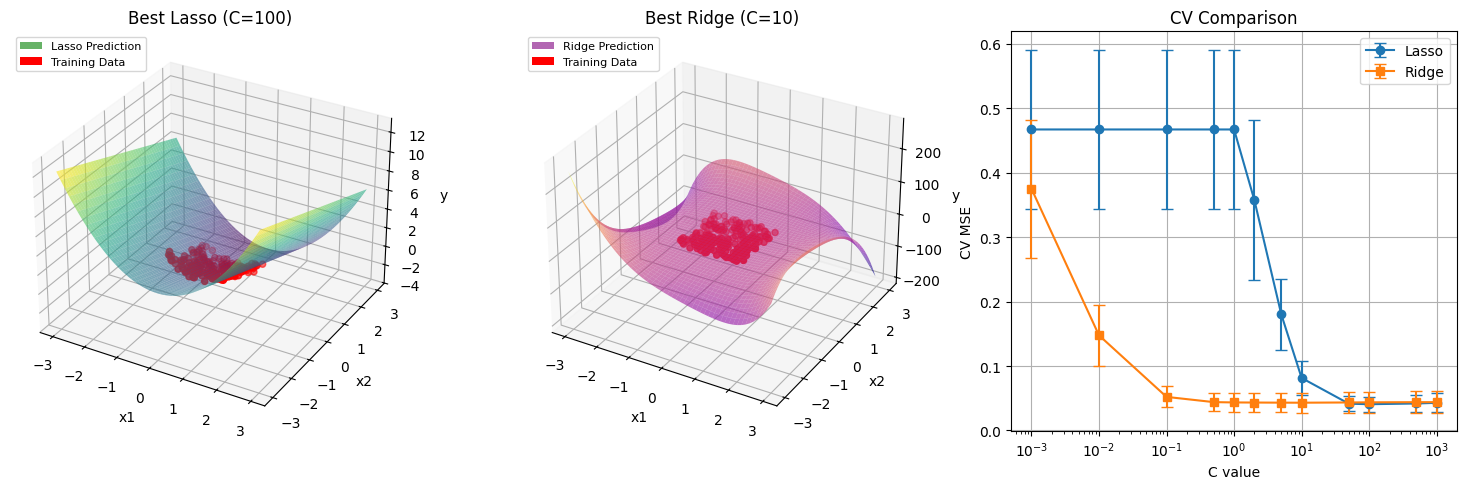

In [75]:
# Final comparison
print("FINAL SUMMARY")
print("=" * 50)

print(f"Dataset: week3.csv")
print(f"Data points: {len(y)}")
print(f"Polynomial degree: 5 ({Xpoly.shape[1]} features)")

print(f"\nBest Lasso: C = {best_C}, CV MSE = {best_mse:.4f}, Coeffs = {len(non_zero_indices)}")
print(f"Best Ridge: C = {best_ridge_C}, CV MSE = {best_ridge_mse:.4f}")

print(f"\nWinner: {'Lasso' if best_mse < best_ridge_mse else 'Ridge'}")

# plot final comparison
from matplotlib.patches import Patch
fig = plt.figure(figsize=(15, 5))

# Lasso surface
final_lasso_pred = final_lasso.predict(Xgrid_poly).reshape(X1.shape)
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot_surface(X1, X2, final_lasso_pred, alpha=0.6, cmap='viridis')
ax1.scatter(X[:,0], X[:,1], y, c='red', s=20)
ax1.set_title(f'Best Lasso (C={best_C})')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')
# Add legend
legend_elements = [Patch(facecolor='green', alpha=0.6, label='Lasso Prediction'),
                   Patch(facecolor='red', label='Training Data')]
ax1.legend(handles=legend_elements, loc='upper left', fontsize=8)

# Ridge surface
final_ridge = Ridge(alpha=1/(2*best_ridge_C))
final_ridge.fit(Xpoly, y)
final_ridge_pred = final_ridge.predict(Xgrid_poly).reshape(X1.shape)
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot_surface(X1, X2, final_ridge_pred, alpha=0.6, cmap='plasma')
ax2.scatter(X[:,0], X[:,1], y, c='red', s=20)
ax2.set_title(f'Best Ridge (C={best_ridge_C})')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y')
# Add legend
legend_elements = [Patch(facecolor='purple', alpha=0.6, label='Ridge Prediction'),
                   Patch(facecolor='red', label='Training Data')]
ax2.legend(handles=legend_elements, loc='upper left', fontsize=8)

# CV comparison
ax3 = fig.add_subplot(1, 3, 3)
ax3.errorbar(C_cv, cv_means, yerr=cv_stds, fmt='o-', capsize=4, label='Lasso')
ax3.errorbar(C_cv, ridge_cv_means, yerr=ridge_cv_stds, fmt='s-', capsize=4, label='Ridge')
ax3.set_xscale('log')
ax3.set_xlabel('C value')
ax3.set_ylabel('CV MSE')
ax3.set_title('CV Comparison')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.savefig('figures/08_final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
